# A notebook to to get true and predicted CTann and RUI for HRApop atlas datasets


## Goal

See [this GitHub issue](https://github.com/x-atlas-consortia/hra-pop/issues/100)


## Import libraries


In [53]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pprint import pprint
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

In [54]:
import hra_api_client

from hra_api_client.api import v1_api as default_api
from hra_api_client.models.sparql_query_request import SparqlQueryRequest

Configure HRA API client and create API instance

In [55]:
# may need to remove `v1`
configuration = hra_api_client.Configuration(
    host="https://apps.humanatlas.io/api"
)

api_client = hra_api_client.ApiClient(configuration)
api_instance = default_api.V1Api(api_client)

## Set global variables


In [56]:
hra_pop_version = "v0.11.1"

## Load data


In [57]:
# df_x = pd.read_csv("data/validation-v7-ctann-rui.csv")
df_x = pd.read_csv(
  f"../../../hra-pop/output-data/{hra_pop_version}/reports/atlas/validation-v7-x-axis.csv")
df_y = pd.read_csv(
  f"../../../hra-pop/output-data/{hra_pop_version}/reports/atlas/validation-v7-y-axis.csv")

## Prepare data for visualization and visualize


In [58]:
df_x

,sex,sample,rui_location,dataset,tool,modality,organ,organId,datasetVsRuiSim
0,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.912194
1,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.674430
2,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,popv,sc_transcriptomics,heart,UBERON:0000948,0.959826
3,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7f-8084249e91cd,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.909598
4,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7f-8084249e91cd,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.419527
...,...,...,...,...,...,...,...,...,...
149,Female,https://entity.api.hubmapconsortium.org/entities/00dfe667dace1ca403c6345ee375d80d,http://purl.org/ccf/1.5/9e77a7b5-e7e8-48e1-a30e-01eeaa300ed8,https://entity.api.hubmapconsortium.org/entities/ce30489adeb0c18b028055b8b60707ca,sc_proteomics,sc_proteomics,skin of body,UBERON:0002097,0.935384
150,Female,https://entity.api.hubmapconsortium.org/entities/007f8a9983b0025ede9b0b645281e440,http://purl.org/ccf/1.5/ee7b09db-e6f5-4114-a8f8-5a19bb3a07c2,https://entity.api.hubmapconsortium.org/entities/fa238ec2a83302fb4af92442c3683a23,sc_proteomics,sc_proteomics,skin of body,UBERON:0002097,0.972769
151,Female,https://entity.api.hubmapconsortium.org/entities/d093d6563dad2457356074c3781d9bea,http://purl.org/ccf/1.5/8959318d-4815-4b51-96f2-5a1096de49f3,https://entity.api.hubmapconsortium.org/entities/00d1a3623dac388773bc7780fcb42797,sc_proteomics,sc_proteomics,spleen,UBERON:0002106,0.990390
152,Female,https://entity.api.hubmapconsortium.org/entities/3d2bc79885fc7720f77fddd2c23f02e5,http://purl.org/ccf/1.5/fa9ecb7f-16d5-4733-bc89-46496a9e886e,https://entity.api.hubmapconsortium.org/entities/d9780d3f4eb9edfe275abaa32ff8633b,popv,sc_transcriptomics,spleen,UBERON:0002106,0.579837


In [59]:
df_y

,sex,rui_location,dataset,tool,predicted_rui,similarity
0,Female,http://purl.org/ccf/1.5/21f2dbfa-f964-4526-bb4b-6b13302b4963,https://entity.api.hubmapconsortium.org/entities/ad693f99fb9006e68a53e97598da1509,azimuth,http://purl.org/ccf/1.5/c5e652ed-7e40-41de-bfc0-a73f05a0c66a,0.663020
1,Female,http://purl.org/ccf/1.5/314450f7-0477-4152-b4d6-cb474cbc0cd7,https://entity.api.hubmapconsortium.org/entities/72b0dc83701c045d954b457baed40697,sc_proteomics,http://purl.org/ccf/1.5/9e77a7b5-e7e8-48e1-a30e-01eeaa300ed8,0.967061
2,Female,http://purl.org/ccf/1.5/43e195fb-0f50-4b67-bff1-b74f68290fc6,https://entity.api.hubmapconsortium.org/entities/2eca1430db3b9a4129bff717925fe932,popv,http://purl.org/ccf/1.5/6acd66b8-2659-4626-bef9-a80f135489ad,0.592259
3,Female,http://purl.org/ccf/1.5/502166ab-e841-4b65-9045-7c386166a9e8,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H7$l...,popv,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,0.942765
4,Female,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H5$h...,popv,http://purl.org/ccf/1.5/05c11830-1526-4472-bd12-ea24dbcfd3cc,0.855615
...,...,...,...,...,...,...
327,Female,http://purl.org/ccf/1.5/05c11830-1526-4472-bd12-ea24dbcfd3cc,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D11$...,azimuth,http://purl.org/ccf/1.5/502166ab-e841-4b65-9045-7c386166a9e8,0.658962
328,Female,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D4$h...,azimuth,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7f-8084249e91cd,0.967719
329,Female,http://purl.org/ccf/1.5/52c4948d-bdc2-4201-a991-61a2c0a565c0,https://entity.api.hubmapconsortium.org/entities/e65175561b4b17da5352e3837aa0e497,azimuth,http://purl.org/ccf/1.5/d77fd4d3-c410-42ea-ad28-7383b3338323,0.788492
330,Female,http://purl.org/ccf/1.5/8959318d-4815-4b51-96f2-5a1096de49f3,https://entity.api.hubmapconsortium.org/entities/00d1a3623dac388773bc7780fcb42797,sc_proteomics,http://purl.org/ccf/1.5/fa9ecb7f-16d5-4733-bc89-46496a9e886e,0.990389


## Compute similarity scores for %AS


### Load atlas enriched dataset graph


In [60]:
ds_graph_path = f"../../../hra-pop/output-data/{hra_pop_version}/atlas-enriched-dataset-graph.jsonld"

with open(ds_graph_path) as f:
  graph = json.load(f)

### Define functions


In [ ]:

def dict_to_vec(dict1: dict, dict2: dict):


  """Takes two dictionaries and returns a tuple of nornalized lists with values (0 if key not present)



  Args:


    dict1 (dict): dictionary 1


    dict2 (dict): dictionary 2


  Returns:


    result (tuple): a tuple with normalized lists


  """



  # initialize result


  dict1_list = []


  dict2_list = []



  # handle shared keys


  shared_keys = set(dict1['collisions'].keys()).intersection(


    dict2['collisions'].keys())



  for key in shared_keys:


    dict1_list.append(dict1['collisions'][key])


    dict2_list.append(dict2['collisions'][key])



  # handle not shared keys


  keys_in_dict1_not_in_dict2 = dict1.keys() - dict2.keys()


  for key in keys_in_dict1_not_in_dict2:


    dict1[key] = 0



  keys_in_dict2_not_in_dict1 = dict2.keys() - dict1.keys()


  for key in keys_in_dict2_not_in_dict1:


    dict1[key] = 0



  return (dict1_list, dict2_list)




def get_as_collision_items(iri: str, get_organ = False):


  """A function to get AS collision items for an IRI (extraction site) and return a dictionary with AS UBERON ID and intersection percentage of the extraction site. 


  This uses https://apps.humanatlas.io/api/#get-/v1/extraction-site to get the rui_location data given the IRI and https://apps.humanatlas.io/api/#post-/v1/collisions to get the collisions



  Args:


    iri (str): an IRI for an extraction site



  Returns:


    a dictionary with the IRI and a nested dictionary with collisions (ID and percentage) 


  """



  result = {



  }
  
 


  # get extraction site


  base_url_extraction_site = "https://apps.humanatlas.io/api/v1/extraction-site?iri="


  extraction_site = ""
  


  response = requests.get(base_url_extraction_site+iri)


  try:
    extraction_site = json.loads(response.text)
  except Exception as e:
    print(f"Non-success status code given {iri}: {e} has {response.status_code}")
    return result  # Or use an empty dictionary, or any other placeholder
  
  try:
    # send extraction site to /collisions endpoints
    collisions = api_instance.collisions(extraction_site)
    for item in collisions:
      result[item['representation_of']] = item['percentage_of_tissue_block']

    if get_organ:
        result['organ'] = extraction_site['placement']['target']
  except Exception as e:
    print(f"Collision error with IRI {iri}: {e}")
    return result  # Or use an empty dictionary, or any other placeholder

  return result




def compute_cosine_similarity_by_as_percentage(iri_1: str, iri_2: str):


  """Takes two IRIs of extraction sites and returns the cosine similarity of their AS percentages



  Args:


          iri_1 (str): An IRI for an extraction site


          iri_2 (str): An IRI for an extraction site



Returns: 


          similarity (float): A cosine similarity


  """



  # Get AS collision items as dict


  dict1 = get_as_collision_items(iri_1)


  dict2 = get_as_collision_items(iri_2)



  # Get a combined set of all keys from both dictionaries


  all_keys = set(dict1.keys()).union(dict2.keys())



  # Create the two lists of values


  values1 = [dict1.get(key, 0) for key in all_keys]


  values2 = [dict2.get(key, 0) for key in all_keys]



  # Compute cosine similarity


  cosine_similarity_value = cosine_similarity([values1], [values2])



  return float(cosine_similarity_value[0][0])

### Loop through pairs of extraction sites (true and predicted) in validation and compute AS% similarity score


In [64]:
# Add a new column with the AS% cosine similarity
df_y['as_percentage_cosine_sim'] = df_y.apply(lambda row: compute_cosine_similarity_by_as_percentage(
  row['rui_location'], row['predicted_rui']), axis=1)

# Save to CSV for optional inspection in external software
df_y.to_csv("output/df_y.csv")

# print for review inline
df_y

Success for http://purl.org/ccf/1.5/21f2dbfa-f964-4526-bb4b-6b13302b4963
Success for {'@context': 'https://hubmapconsortium.github.io/ccf-ontology/ccf-context.jsonld', '@id': 'http://purl.org/ccf/1.5/21f2dbfa-f964-4526-bb4b-6b13302b4963', 'placement': {'@id': 'http://purl.org/ccf/1.5/21f2dbfa-f964-4526-bb4b-6b13302b4963_placement', '@type': 'SpatialPlacement', 'source': 'http://purl.org/ccf/1.5/21f2dbfa-f964-4526-bb4b-6b13302b4963', 'target': 'http://purl.org/ccf/latest/ccf.owl#VHFRightKidneyV1.1', 'rotation_order': 'XYZ', 'rotation_units': 'degree', 'scaling_units': 'ratio', 'translation_units': 'millimeter', 'x_rotation': 0, 'x_scaling': 1, 'x_translation': 48.53, 'y_rotation': 0, 'y_scaling': 1, 'y_translation': 41.208, 'z_rotation': 0, 'z_scaling': 1, 'z_translation': 44.27, 'placement_date': '2024-03-29'}, '@type': 'SpatialEntity', 'ccf_annotations': ['http://purl.obolibrary.org/obo/UBERON_0000362', 'http://purl.obolibrary.org/obo/UBERON_0001225', 'http://purl.obolibrary.org/obo/U

,sex,rui_location,dataset,tool,predicted_rui,similarity,as_percentage_cosine_sim
0,Female,http://purl.org/ccf/1.5/21f2dbfa-f964-4526-bb4b-6b13302b4963,https://entity.api.hubmapconsortium.org/entities/ad693f99fb9006e68a53e97598da1509,azimuth,http://purl.org/ccf/1.5/c5e652ed-7e40-41de-bfc0-a73f05a0c66a,0.663020,0.000000
1,Female,http://purl.org/ccf/1.5/314450f7-0477-4152-b4d6-cb474cbc0cd7,https://entity.api.hubmapconsortium.org/entities/72b0dc83701c045d954b457baed40697,sc_proteomics,http://purl.org/ccf/1.5/9e77a7b5-e7e8-48e1-a30e-01eeaa300ed8,0.967061,1.000000
2,Female,http://purl.org/ccf/1.5/43e195fb-0f50-4b67-bff1-b74f68290fc6,https://entity.api.hubmapconsortium.org/entities/2eca1430db3b9a4129bff717925fe932,popv,http://purl.org/ccf/1.5/6acd66b8-2659-4626-bef9-a80f135489ad,0.592259,0.000000
3,Female,http://purl.org/ccf/1.5/502166ab-e841-4b65-9045-7c386166a9e8,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H7$l...,popv,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,0.942765,0.000000
4,Female,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H5$h...,popv,http://purl.org/ccf/1.5/05c11830-1526-4472-bd12-ea24dbcfd3cc,0.855615,0.132641
...,...,...,...,...,...,...,...
327,Female,http://purl.org/ccf/1.5/05c11830-1526-4472-bd12-ea24dbcfd3cc,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D11$...,azimuth,http://purl.org/ccf/1.5/502166ab-e841-4b65-9045-7c386166a9e8,0.658962,0.000000
328,Female,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D4$h...,azimuth,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7f-8084249e91cd,0.967719,0.000000
329,Female,http://purl.org/ccf/1.5/52c4948d-bdc2-4201-a991-61a2c0a565c0,https://entity.api.hubmapconsortium.org/entities/e65175561b4b17da5352e3837aa0e497,azimuth,http://purl.org/ccf/1.5/d77fd4d3-c410-42ea-ad28-7383b3338323,0.788492,0.000000
330,Female,http://purl.org/ccf/1.5/8959318d-4815-4b51-96f2-5a1096de49f3,https://entity.api.hubmapconsortium.org/entities/00d1a3623dac388773bc7780fcb42797,sc_proteomics,http://purl.org/ccf/1.5/fa9ecb7f-16d5-4733-bc89-46496a9e886e,0.990389,0.996546


## Visualize


### Create combined DataFrame


In [65]:
# Merging on two columns (key1 and key2)
df_merged = pd.merge(
  df_x, df_y, on=['dataset', 'tool', 'rui_location', 'sex'], how='inner')

# rename similarity columns for plotting


df_merged = df_merged.rename(columns={
  "datasetVsRuiSim": "ctann_sim",
  # RUI (y axis) cosine sim between dataset cell summary vs PREDICTED (most similar) rui location cell summary (*except* its TRUE rui location)
  "similarity": "rui_sim_by_cell_summary",
  "as_percentage_cosine_sim": "rui_sim_as_percentage"
})

df_merged

,sex,sample,rui_location,dataset,tool,modality,organ,organId,ctann_sim,predicted_rui,rui_sim_by_cell_summary,rui_sim_as_percentage
0,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.912194,http://purl.org/ccf/1.5/05c11830-1526-4472-bd12-ea24dbcfd3cc,0.917983,0.532793
1,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.674430,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,0.930042,0.000000
2,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,popv,sc_transcriptomics,heart,UBERON:0000948,0.959826,http://purl.org/ccf/1.5/04baf323-eda0-4f72-bea1-aa943aa70894,0.959826,1.000000
3,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7f-8084249e91cd,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.909598,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,0.918074,0.000000
4,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7f-8084249e91cd,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.419527,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,0.854758,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
149,Female,https://entity.api.hubmapconsortium.org/entities/00dfe667dace1ca403c6345ee375d80d,http://purl.org/ccf/1.5/9e77a7b5-e7e8-48e1-a30e-01eeaa300ed8,https://entity.api.hubmapconsortium.org/entities/ce30489adeb0c18b028055b8b60707ca,sc_proteomics,sc_proteomics,skin of body,UBERON:0002097,0.935384,http://purl.org/ccf/1.5/eb92e0e2-838b-4689-b13c-07c3ce31eaf0,0.935384,1.000000
150,Female,https://entity.api.hubmapconsortium.org/entities/007f8a9983b0025ede9b0b645281e440,http://purl.org/ccf/1.5/ee7b09db-e6f5-4114-a8f8-5a19bb3a07c2,https://entity.api.hubmapconsortium.org/entities/fa238ec2a83302fb4af92442c3683a23,sc_proteomics,sc_proteomics,skin of body,UBERON:0002097,0.972769,http://purl.org/ccf/1.5/9e77a7b5-e7e8-48e1-a30e-01eeaa300ed8,0.972769,1.000000
151,Female,https://entity.api.hubmapconsortium.org/entities/d093d6563dad2457356074c3781d9bea,http://purl.org/ccf/1.5/8959318d-4815-4b51-96f2-5a1096de49f3,https://entity.api.hubmapconsortium.org/entities/00d1a3623dac388773bc7780fcb42797,sc_proteomics,sc_proteomics,spleen,UBERON:0002106,0.990390,http://purl.org/ccf/1.5/fa9ecb7f-16d5-4733-bc89-46496a9e886e,0.990389,0.996546
152,Female,https://entity.api.hubmapconsortium.org/entities/3d2bc79885fc7720f77fddd2c23f02e5,http://purl.org/ccf/1.5/fa9ecb7f-16d5-4733-bc89-46496a9e886e,https://entity.api.hubmapconsortium.org/entities/d9780d3f4eb9edfe275abaa32ff8633b,popv,sc_transcriptomics,spleen,UBERON:0002106,0.579837,http://purl.org/ccf/1.5/6febbcea-502d-466e-bb26-6e3eb8240902,0.580671,0.621882


### Subset data (if needed)

In [66]:
pd.options.display.max_colwidth = 100

# set subset to full df
df_subset = df_merged

# uncomment if not subsetting 
# df_subset = df_merged[(df_merged['rui_sim_as_percentage'] < 0.1)]
df_subset

,sex,sample,rui_location,dataset,tool,modality,organ,organId,ctann_sim,predicted_rui,rui_sim_by_cell_summary,rui_sim_as_percentage
0,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.912194,http://purl.org/ccf/1.5/05c11830-1526-4472-bd12-ea24dbcfd3cc,0.917983,0.532793
1,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.674430,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,0.930042,0.000000
2,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,popv,sc_transcriptomics,heart,UBERON:0000948,0.959826,http://purl.org/ccf/1.5/04baf323-eda0-4f72-bea1-aa943aa70894,0.959826,1.000000
3,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7f-8084249e91cd,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.909598,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,0.918074,0.000000
4,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7f-8084249e91cd,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.419527,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,0.854758,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
149,Female,https://entity.api.hubmapconsortium.org/entities/00dfe667dace1ca403c6345ee375d80d,http://purl.org/ccf/1.5/9e77a7b5-e7e8-48e1-a30e-01eeaa300ed8,https://entity.api.hubmapconsortium.org/entities/ce30489adeb0c18b028055b8b60707ca,sc_proteomics,sc_proteomics,skin of body,UBERON:0002097,0.935384,http://purl.org/ccf/1.5/eb92e0e2-838b-4689-b13c-07c3ce31eaf0,0.935384,1.000000
150,Female,https://entity.api.hubmapconsortium.org/entities/007f8a9983b0025ede9b0b645281e440,http://purl.org/ccf/1.5/ee7b09db-e6f5-4114-a8f8-5a19bb3a07c2,https://entity.api.hubmapconsortium.org/entities/fa238ec2a83302fb4af92442c3683a23,sc_proteomics,sc_proteomics,skin of body,UBERON:0002097,0.972769,http://purl.org/ccf/1.5/9e77a7b5-e7e8-48e1-a30e-01eeaa300ed8,0.972769,1.000000
151,Female,https://entity.api.hubmapconsortium.org/entities/d093d6563dad2457356074c3781d9bea,http://purl.org/ccf/1.5/8959318d-4815-4b51-96f2-5a1096de49f3,https://entity.api.hubmapconsortium.org/entities/00d1a3623dac388773bc7780fcb42797,sc_proteomics,sc_proteomics,spleen,UBERON:0002106,0.990390,http://purl.org/ccf/1.5/fa9ecb7f-16d5-4733-bc89-46496a9e886e,0.990389,0.996546
152,Female,https://entity.api.hubmapconsortium.org/entities/3d2bc79885fc7720f77fddd2c23f02e5,http://purl.org/ccf/1.5/fa9ecb7f-16d5-4733-bc89-46496a9e886e,https://entity.api.hubmapconsortium.org/entities/d9780d3f4eb9edfe275abaa32ff8633b,popv,sc_transcriptomics,spleen,UBERON:0002106,0.579837,http://purl.org/ccf/1.5/6febbcea-502d-466e-bb26-6e3eb8240902,0.580671,0.621882


### Build plot


Functions for making plots


In [67]:
def make_validation_scattergraph(x: float, y: float, palette: str, col: str, row: str, hue: str, x_label: str, y_label: str):
    """A wrapper function around a seaborn FacetGrid to make multiple versions of the validation scattergraph

    Args:
                    x (float): x-value
                    y (float): y-value
                    palette (str): Name for color palette
                    col (str): Column of facet grid
                    row (str): Row of facet grid
                    hue (str): Color for points
                    x_label (str): Label on x-axis
            y_label (str): Label on y-axis
    """

    # Create a custom color palette
    custom_palette = sns.color_palette(palette)

    # set font size
    sns.set_theme(font_scale=2)

    # Create FacetGrid
    g = sns.FacetGrid(
        df_subset,
        col=col,
        row=row,
        hue=hue,
        palette=custom_palette,
        height=5,
        aspect=2
    )

    # Set the style of the plot
    # Options: "white", "dark", "whitegrid", "darkgrid", "ticks"
    sns.set_style("whitegrid")

    # Create a scatter plot
    g.map(sns.scatterplot, x, y)

    # Set labels
    g.set(xlabel=x_label, ylabel=y_label)

    # Add a legend
    g.add_legend()

    # Show the plot
    plt.show()

### Data dictionary


| Axis             | Variable                | Explanation                                                                                                                                 |
| ---------------- | ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- |
| x                | ctann_sim               | CTann (x axis) Cosine sim between TRUE cell summary of input dataset and PREDICTED cell summary of input RUI location (as computed by US 1) |
| y (cell summary) | rui_sim_by_cell_summary | RUI (y axis) cosine sim between dataset cell summary vs PREDICTED (most similar) rui location cell summary (_except_ its TRUE rui location) |
| y (AS%)          | rui_sim_as_percentage   | RUI (y axis) cosine sim between AS% of TRUE and PREDICTED rui (determined by cosine sim captured as `ruiVsTopPredictedRuiSim` in [this query](https://github.com/x-atlas-consortia/hra-pop/blob/main/queries/atlas/validation-v7-ctann-rui.rq)). Could also use `datasetVsRuiSim`, which is the sim between a dataset and its OWN rui location                                            
                                  |


### CTann vs RUI AS% similarity


In [68]:
# Correlation
stats = df_subset[['ctann_sim', 'rui_sim_as_percentage']]
stats.corr(min_periods=3)

,ctann_sim,rui_sim_as_percentage
ctann_sim,1.000000,0.289755
rui_sim_as_percentage,0.289755,1.000000


In [69]:
# Mean, STDDEV, min, etc.
stats.describe()

,ctann_sim,rui_sim_as_percentage
count,154.000000,154.000000
mean,0.805470,0.253922
std,0.161208,0.364045
min,0.240093,0.000000
25%,0.683055,0.000000
50%,0.878216,0.000000
75%,0.924782,0.532793
max,0.990575,1.000000


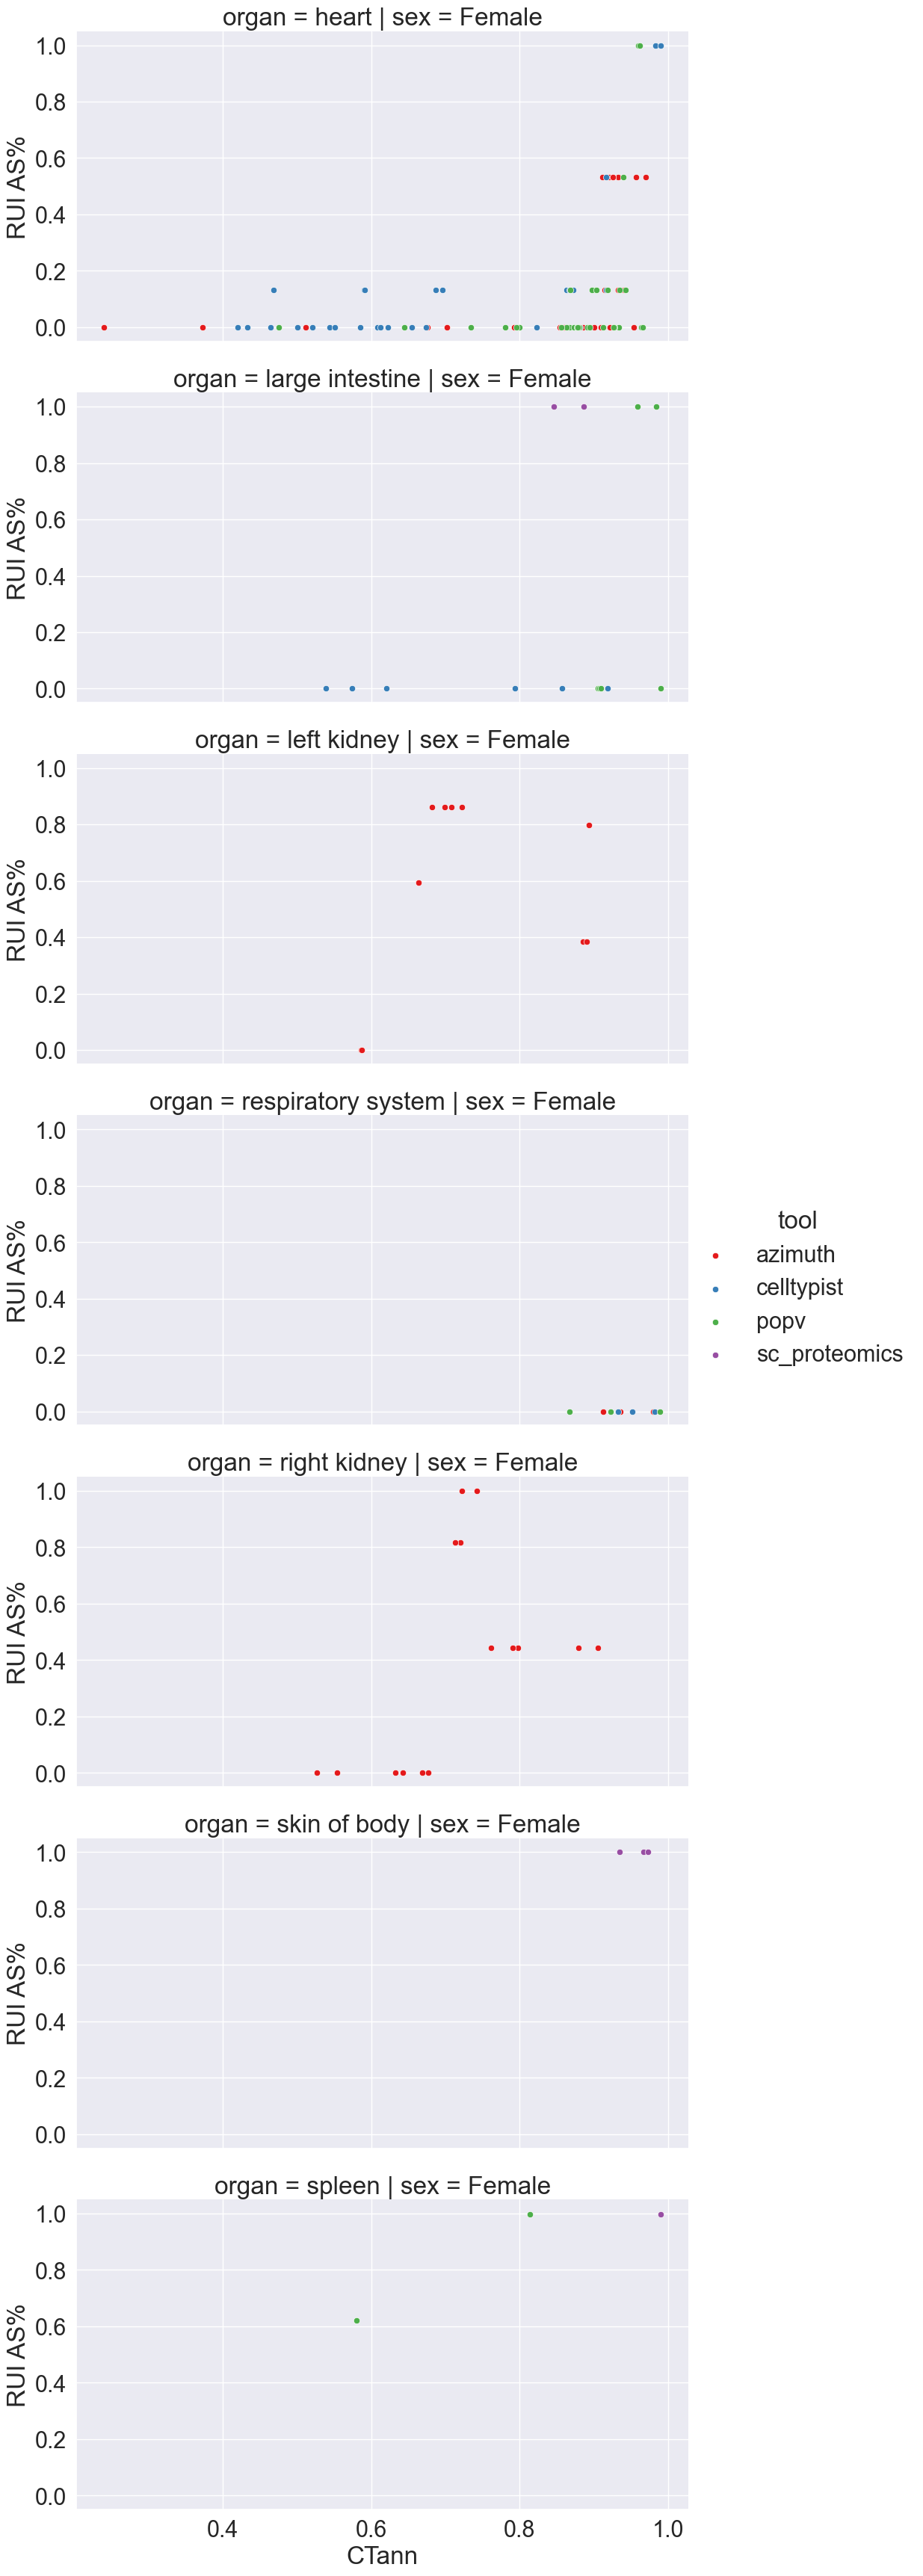

In [70]:
make_validation_scattergraph(
  "ctann_sim", "rui_sim_as_percentage", "Set1", "sex", "organ", "tool", "CTann", "RUI AS%")

# Old

### CTann vs RUI cosine sim between dataset cell summary vs PREDICTED (most similar) rui location cell summary &#x2705;


In [71]:
# Correlation
stats = df_subset[['ctann_sim', 'rui_sim_by_cell_summary']]
stats.corr(min_periods=3)

,ctann_sim,rui_sim_by_cell_summary
ctann_sim,1.000000,0.488916
rui_sim_by_cell_summary,0.488916,1.000000


In [72]:
# Mean, STDDEV, min, etc.
stats.describe()

,ctann_sim,rui_sim_by_cell_summary
count,154.000000,154.000000
mean,0.805470,0.851908
std,0.161208,0.122310
min,0.240093,0.477091
25%,0.683055,0.752970
50%,0.878216,0.909450
75%,0.924782,0.936973
max,0.990575,0.992262


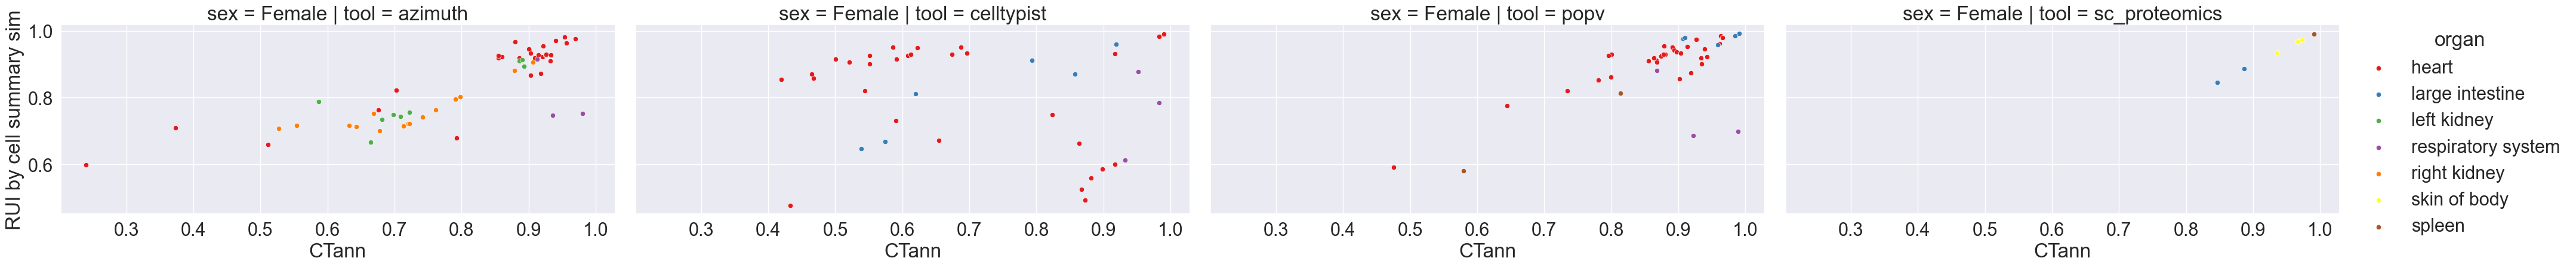

In [73]:
make_validation_scattergraph(
  "ctann_sim", "rui_sim_by_cell_summary", "Set1", "tool", "sex", "organ", "CTann", "RUI by cell summary sim")